In [2]:
# %pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/fb/99/2364cc073662517335383f68a10549c6b75486b99f0d671179e4dd8252d6/shap-0.43.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/88/60/aa67255e6e166ef6541d007f22470fc459b8c7b66fb6790fd735d0bcd951/numba-0.58.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for llvmlite<0.42,>=0.41.0dev0 from https://files.pythonhosted.org/packages/12/f4/9bc78ef5d52cbe595a849d332c872583a6294afff6f5317de6dce4abbe55/llvmlite-0.41.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.4/445.4 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 50.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 41.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, r

In [62]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import logging
import os

# import ipython
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

from imblearn.under_sampling  import RandomUnderSampler


In [17]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

X

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


In [18]:
X_display

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [75]:
def features_engineering(data_train, data_test):

    # Cette fonction regroupe toutes les opérations de features engineering
    # mises en place sur les sets train & test

    #############################################
    # LABEL ENCODING
    #############################################
    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in data_train:
        if data_train[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(data_train[col].unique())) <= 2:
                # Train on the training data
                le.fit(data_train[col])
                # Transform both training and testing data
                data_train[col] = le.transform(data_train[col])
                data_test[col] = le.transform(data_test[col])
                
                # Keep track of how many columns were label encoded
                le_count += 1

    ############################################
    # ONE HOT ENCODING
    ############################################
    # one-hot encoding of categorical variables
    data_train = pd.get_dummies(data_train)
    data_test = pd.get_dummies(data_test)

    train_labels = data_train['TARGET']
    # Align the training and testing data, keep only columns present in both dataframes
    data_train, data_test = data_train.align(data_test, join = 'inner', axis = 1)
    # Add the target back in
    data_train['TARGET'] = train_labels

    ############################################
    # VALEURS ABERRANTES
    ############################################
    # Create an anomalous flag column
    data_train['DAYS_EMPLOYED_ANOM'] = data_train["DAYS_EMPLOYED"] == 365243
    # Replace the anomalous values with nan
    data_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    data_test['DAYS_EMPLOYED_ANOM'] = data_test["DAYS_EMPLOYED"] == 365243
    data_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

    # Traitement des valeurs négatives
    data_train['DAYS_BIRTH'] = abs(data_train['DAYS_BIRTH'])

    ############################################
    # CREATION DE VARIABLES
    ############################################
    # CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
    # ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
    # CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
    # DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

    # Dans cet état d'esprit, nous pouvons créer quelques fonctionnalités qui tentent de capturer ce que nous pensons
    # peut être important pour savoir si un client fera défaut sur un prêt.
    # Ici, je vais utiliser cinq fonctionnalités inspirées de ce script d'Aguiar :

    # CREDIT_INCOME_PERCENT : le pourcentage du montant du crédit par rapport aux revenus d'un client
    # ANNUITY_INCOME_PERCENT : le pourcentage de la rente du prêt par rapport aux revenus d'un client
    # CREDIT_TERM : la durée du versement en mois (puisque la rente est le montant mensuel dû
    # DAYS_EMPLOYED_PERCENT : le pourcentage de jours employés par rapport à l'âge du client

    data_train_domain = data_train.copy()
    data_test_domain = data_test.copy()

    # data_train_domain['CREDIT_INCOME_PERCENT'] = data_train_domain['AMT_CREDIT'] / data_train_domain['AMT_INCOME_TOTAL']
    # data_train_domain['ANNUITY_INCOME_PERCENT'] = data_train_domain['AMT_ANNUITY'] / data_train_domain['AMT_INCOME_TOTAL']
    # data_train_domain['CREDIT_TERM'] = data_train_domain['AMT_ANNUITY'] / data_train_domain['AMT_CREDIT']
    # data_train_domain['DAYS_EMPLOYED_PERCENT'] = data_train_domain['DAYS_EMPLOYED'] / data_train_domain['DAYS_BIRTH']

    # data_test_domain['CREDIT_INCOME_PERCENT'] = data_test_domain['AMT_CREDIT'] / data_test_domain['AMT_INCOME_TOTAL']
    # data_test_domain['ANNUITY_INCOME_PERCENT'] = data_test_domain['AMT_ANNUITY'] / data_test_domain['AMT_INCOME_TOTAL']
    # data_test_domain['CREDIT_TERM'] = data_test_domain['AMT_ANNUITY'] / data_test_domain['AMT_CREDIT']
    # data_test_domain['DAYS_EMPLOYED_PERCENT'] = data_test_domain['DAYS_EMPLOYED'] / data_test_domain['DAYS_BIRTH']
    
    # Calcul de nouvelles caractéristiques basées sur les données du jeu d'entraînement

    # Pourcentage du crédit par rapport au revenu total
    data_train_domain['CREDIT_INCOME_PERCENT'] = data_train_domain['AMT_CREDIT'] / data_train_domain['AMT_INCOME_TOTAL']

    # Pourcentage de l'annuité (paiement mensuel du crédit) par rapport au revenu total
    data_train_domain['ANNUITY_INCOME_PERCENT'] = data_train_domain['AMT_ANNUITY'] / data_train_domain['AMT_INCOME_TOTAL']

    # Terme du crédit : rapport de l'annuité au montant du crédit
    data_train_domain['CREDIT_TERM'] = data_train_domain['AMT_ANNUITY'] / data_train_domain['AMT_CREDIT']

    # Pourcentage des jours d'emploi par rapport à l'âge en jours (une mesure de la stabilité financière)
    data_train_domain['DAYS_EMPLOYED_PERCENT'] = data_train_domain['DAYS_EMPLOYED'] / data_train_domain['DAYS_BIRTH']

    # Calcul de nouvelles caractéristiques basées sur les données du jeu de test

    # Pourcentage du crédit par rapport au revenu total
    data_test_domain['CREDIT_INCOME_PERCENT'] = data_test_domain['AMT_CREDIT'] / data_test_domain['AMT_INCOME_TOTAL']

    # Pourcentage de l'annuité par rapport au revenu total
    data_test_domain['ANNUITY_INCOME_PERCENT'] = data_test_domain['AMT_ANNUITY'] / data_test_domain['AMT_INCOME_TOTAL']

    # Terme du crédit : rapport de l'annuité au montant du crédit
    data_test_domain['CREDIT_TERM'] = data_test_domain['AMT_ANNUITY'] / data_test_domain['AMT_CREDIT']

    # Pourcentage des jours d'emploi par rapport à l'âge en jours
    data_test_domain['DAYS_EMPLOYED_PERCENT'] = data_test_domain['DAYS_EMPLOYED'] / data_test_domain['DAYS_BIRTH']

    # Explication :
    # Ce code calcule plusieurs nouvelles caractéristiques (features) pour les jeux de données d'entraînement et de test.
    # Ces caractéristiques sont créées en effectuant des opérations mathématiques sur les colonnes existantes.
    # Elles peuvent être utiles pour mieux comprendre les relations entre les variables et améliorer la performance des modèles de machine learning.
    # Par exemple, le pourcentage du crédit par rapport au revenu total peut donner des informations sur la capacité de remboursement d'un emprunteur.
    # De même, le pourcentage de l'annuité par rapport au revenu total peut aider à évaluer si un client peut gérer le paiement mensuel d'un crédit.
    # Ces caractéristiques nouvellement créées sont souvent appelées "ingénierie des caractéristiques" et font partie du processus d'exploration de données.

    return data_train_domain, data_test_domain


def preprocesseur(df_train, df_test):
    
    # Cette fonction permet d'imputer les valeurs manquantes dans
    # chaque dataset et aussi d'appliquer un MinMaxScaler

    # Drop the target from the training data
    if "TARGET" in df_train:
        train = df_train.drop(columns = ["TARGET"])
    else:
        train = df_train.copy()
    
    
    logging.info("# Feature names")
    # Feature names
    features = list(train.columns)
    
    logging.info("# Median imputation")
    # Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')
    
    logging.info("# Scale each")
    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))
    
    logging.info("# Replace the")
    # Replace the boolean column by numerics values 
    train["DAYS_EMPLOYED_ANOM"] = train["DAYS_EMPLOYED_ANOM"].astype("int")
    
    logging.info("# Fit on")
    # Fit on the training data
    imputer.fit(train)
    
    logging.info("# Transform both")
    # Transform both training and testing data
    train = imputer.transform(train)
    test = imputer.transform(df_test)
    
    logging.info("# Repeat with")
    # Repeat with the scaler
    logging.info("scaler")
    scaler.fit(train)
    logging.info("scale train")
    train = scaler.transform(train)
    logging.info("scale test")
    test = scaler.transform(test)
    
    logging.info(train)

    return train, test

def data_resampler(df_train, target):

    rsp = RandomUnderSampler()
    X_rsp, y_rsp = rsp.fit_resample(df_train, target["TARGET"])

    return X_rsp, y_rsp

# Fonction pour l'équilibrage des données avec SMOTE
def data_resampler_SMOTE(df_train, target):
    smote = SMOTE(sampling_strategy='auto', random_state=0)
    X_smote, y_smote = smote.fit_resample(df_train, target["TARGET"])
    return X_smote, y_smote

def entrainement_XGBoost(X, y):

    # Configuration de la meilleure itération trouvée par le RandomizeSearchCV
    # Optimized n_estimator=1144
    clf_xgb = xgb.XGBClassifier(booster='gbtree',
                                colsample_bytree=0.6784538670198459,              
                                eval_metric='auc',
                                learning_rate=0.10310087264740633,
                                max_depth=6, 
                                min_child_weight=2,       
                                n_estimators=150,         
                                objective='binary:logistic', 
                                random_state=0,             
                                subsample=0.4915549740714592,
                                n_jobs = -1
                                )

    clf_xgb.fit(X, y)

    return clf_xgb

def entrainement_knn(df):

    print("En cours...")
    knn = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(df)

    return knn 


In [5]:
data_train = pd.read_csv("application_train.csv")
data_test = pd.read_csv("application_test.csv")

In [76]:
# On prépare les données
feature_train, feature_test = features_engineering(data_train, data_test)

print("Features engineering done")
# On fait le préprocessing des données

df_train, df_test = preprocesseur(feature_train, feature_test)
# On transforme le dataset de test préparé en variabe
# globale, car il est utilisé dans la fonction predict
train = df_train.copy()

test = df_test.copy()

print("Preprocessing done")
# On fait un resampling des données d'entraînement
X, y = data_resampler(df_train, data_train)
print("Resampling done")

# Équilibrage des données d'entraînement avec SMOTE
X, y = data_resampler_SMOTE(df_train, data_train)
print("Resampling SMOTE done")    

# On entraîne le modèle et on le transforme en
# variable globale pour la fonction predict
clf_xgb = entrainement_XGBoost(X, y)
print("Training xgboost done")

knn = entrainement_knn(df_train)
print("Training knn done")

Features engineering done
Preprocessing done
Resampling done
Resampling SMOTE done
Training xgboost done
En cours...
Training knn done


In [77]:

clf_xgb.save_model("xgb.model")


In [ ]:
clf_xgb.best

In [71]:
import pickle

pickle.dump(clf_xgb, open("xgb.pickle", "wb"))

In [35]:
X

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.51559629e-02, 3.57844077e-01, 9.04422633e-01],
       [1.00010001e-04, 8.59771301e-05, 0.00000000e+00, ...,
        9.26379466e-02, 2.35427700e-02, 8.99338279e-01],
       [2.00020002e-04, 1.71954260e-04, 1.00000000e+00, ...,
        6.90958827e-02, 2.49446139e-01, 9.84317961e-01],
       ...,
       [4.17840968e-01, 4.19160271e-01, 0.00000000e+00, ...,
        1.76346724e-01, 5.79918753e-01, 9.64988758e-01],
       [4.08888680e-01, 4.09850645e-01, 0.00000000e+00, ...,
        1.84240555e-01, 3.41773423e-01, 8.47329178e-01],
       [4.82442165e-01, 4.84596123e-01, 0.00000000e+00, ...,
        1.19239613e-01, 3.01618961e-01, 7.21140692e-01]])

In [41]:
shap.initjs()

explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(X)

df_shap = feature_train.loc[:, ~feature_train.columns.str.contains('^Unnamed')]


In [40]:
shap.force_plot(explainer.expected_value, shap_values[0, :], df_shap.iloc[0, :])

In [ ]:
shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], df_shap.iloc[:1000, :]
)



In [58]:
shap_values

array([[-0.34243977, -0.18935448,  0.03066652, ..., -0.01153382,
         0.22202967,  0.09670372],
       [-0.4469906 , -0.1882106 ,  0.01171607, ..., -0.10577412,
        -0.66645855,  0.04232501],
       [-0.21672922, -0.23466498, -0.35692367, ..., -0.09585913,
         0.11950927,  0.04378919],
       ...,
       [ 0.03468257,  0.0569595 ,  0.02426678, ..., -0.00403745,
         0.2641186 , -0.04638821],
       [ 0.03883905,  0.03399208,  0.01667367, ...,  0.00953728,
         0.26431274,  0.07132506],
       [ 0.05434328,  0.04020624,  0.010865  , ...,  0.09102877,
         0.30324274,  0.01423697]], dtype=float32)

In [59]:
df_shap

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,True,False,True,1,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,False,False,True,0,False,4.790750,0.132217,0.027598,-0.070862
2,100004,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,0,False,2.000000,0.100000,0.050000,-0.011814
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,0,False,2.316167,0.219900,0.094941,-0.159905
4,100007,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,0,False,4.222222,0.179963,0.042623,-0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,111629,1,0,1,1,1,135000.0,270000.0,13500.0,270000.0,...,False,True,False,True,0,False,2.000000,0.100000,0.050000,-0.235638
9996,111630,0,0,1,1,0,166500.0,1006920.0,51543.0,900000.0,...,False,False,False,False,0,False,6.047568,0.309568,0.051189,-0.238410
9997,111631,0,1,1,1,0,225000.0,497520.0,53581.5,450000.0,...,False,False,False,False,0,False,2.211200,0.238140,0.107697,-0.088442
9998,111632,0,0,0,0,0,360000.0,348264.0,27643.5,315000.0,...,False,False,False,False,0,False,0.967400,0.076787,0.079375,-0.102390


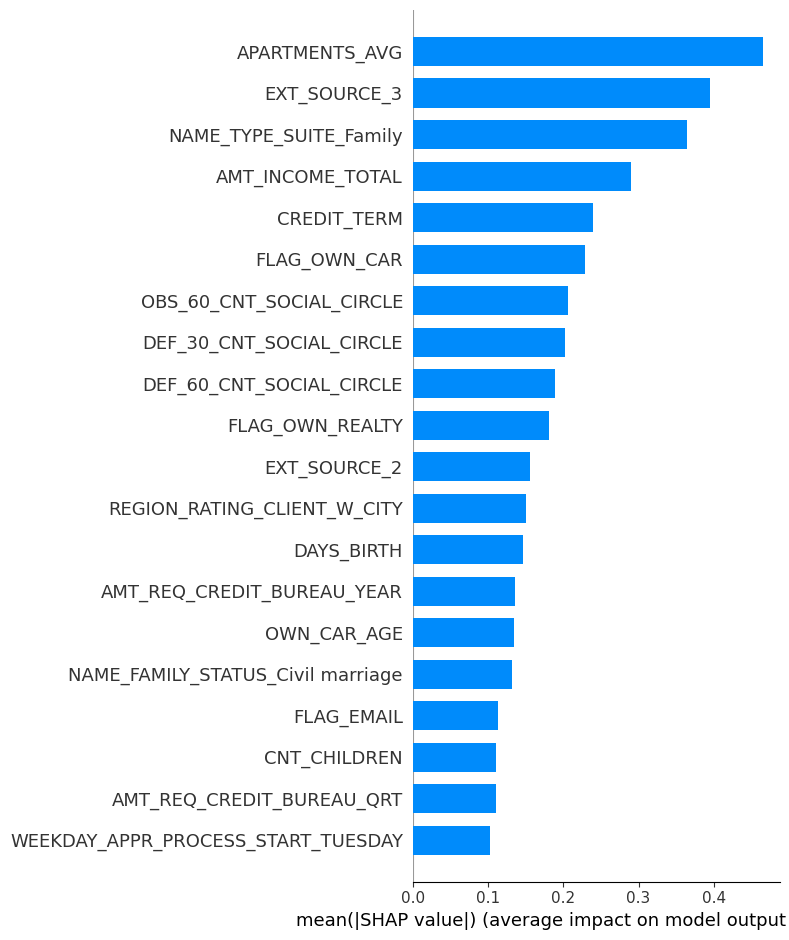

In [66]:
shap.summary_plot(shap_values, df_shap, plot_type="bar", show=False)

plt.savefig("test.png")



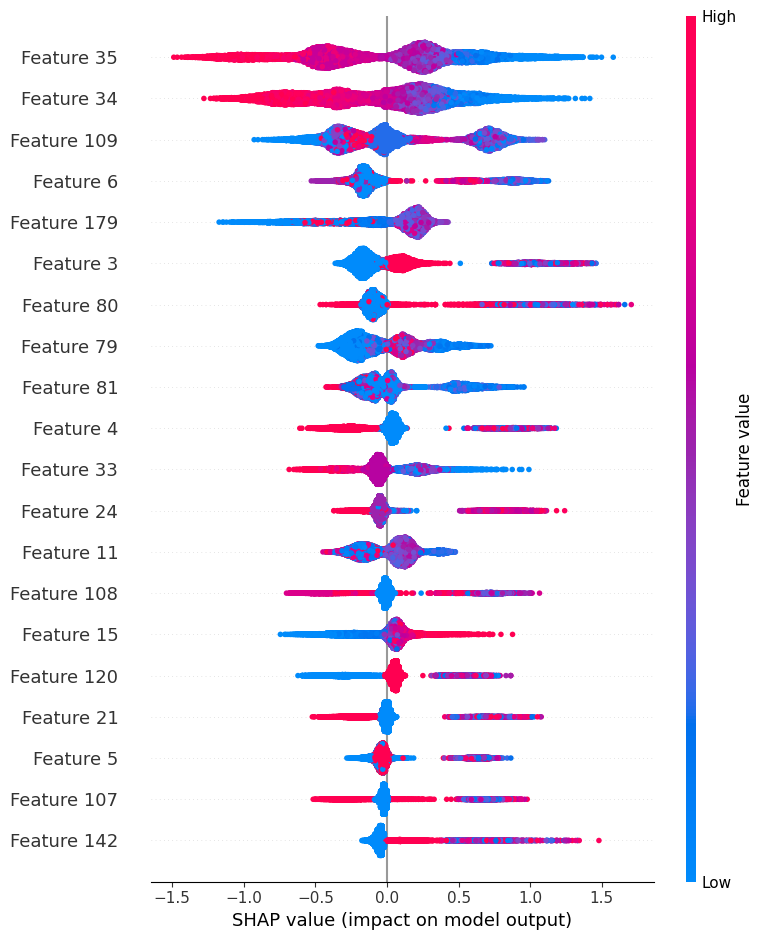

In [46]:
shap.summary_plot(shap_values, X)

In [47]:
shap_values

array([[-0.34243977, -0.18935448,  0.03066652, ..., -0.01153382,
         0.22202967,  0.09670372],
       [-0.4469906 , -0.1882106 ,  0.01171607, ..., -0.10577412,
        -0.66645855,  0.04232501],
       [-0.21672922, -0.23466498, -0.35692367, ..., -0.09585913,
         0.11950927,  0.04378919],
       ...,
       [ 0.03468257,  0.0569595 ,  0.02426678, ..., -0.00403745,
         0.2641186 , -0.04638821],
       [ 0.03883905,  0.03399208,  0.01667367, ...,  0.00953728,
         0.26431274,  0.07132506],
       [ 0.05434328,  0.04020624,  0.010865  , ...,  0.09102877,
         0.30324274,  0.01423697]], dtype=float32)

In [53]:
explainer.expected_value



0.038860895

In [54]:
Xlist = X.tolist()

In [56]:
np.asarray(Xlist)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.51559629e-02, 3.57844077e-01, 9.04422633e-01],
       [1.00010001e-04, 8.59771301e-05, 0.00000000e+00, ...,
        9.26379466e-02, 2.35427700e-02, 8.99338279e-01],
       [2.00020002e-04, 1.71954260e-04, 1.00000000e+00, ...,
        6.90958827e-02, 2.49446139e-01, 9.84317961e-01],
       ...,
       [4.17840968e-01, 4.19160271e-01, 0.00000000e+00, ...,
        1.76346724e-01, 5.79918753e-01, 9.64988758e-01],
       [4.08888680e-01, 4.09850645e-01, 0.00000000e+00, ...,
        1.84240555e-01, 3.41773423e-01, 8.47329178e-01],
       [4.82442165e-01, 4.84596123e-01, 0.00000000e+00, ...,
        1.19239613e-01, 3.01618961e-01, 7.21140692e-01]])